## Download and unzip datasets

In [ ]:
!wget https://www.dropbox.com/s/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip
!unzip unipi_kinematic_AIS_jan_feb2018.zip

--2021-10-06 15:35:27--  https://www.dropbox.com/s/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip [following]
--2021-10-06 15:35:27--  https://www.dropbox.com/s/raw/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc49398c6e39a7aa6f522993a8fd.dl.dropboxusercontent.com/cd/0/inline/BXikAu6Uh23bwai0GEsOsxOcSB44q6YV9DIcpepe3YxjIj7Z5MN6I3WjsBBkjtRJewp6qbwt1SusroGjVXwsWh9-c8xRPlzYlwFHunHifT1Su0xskT5YBMmghr_gaILkEpA1gdhASAZA9jaS-nDa6kDY/file# [following]
--2021-10-06 15:35:28--  https://uc49398c6e39a7aa6f522993a8fd.dl.dropboxusercontent.com/cd/0/inline/BXikAu6Uh23bwai0GEsOs

## Install GeoPandas

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 30.7 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 69.0 MB/s 


## Imports

In [ ]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('unipi_kinematic_AIS_jan2018.csv', sep=';')

In [ ]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lat, df.lon))

## GeoSeries
This is the same as the following
```
gdf = gpd.GeoDataFrame.from_postgis(traj_sql, conn, geom_col='geom')
print(gdf.geom.x)
```

In [ ]:
geom = gpd.geoseries.GeoSeries(df.geometry)
print(geom.x)

0          37.947417
1          37.949492
2          37.944715
3          37.946955
4          37.943502
             ...    
5695686    37.930905
5695687    37.951617
5695688    37.950767
5695689    37.944913
5695690    37.954187
Length: 5695691, dtype: float64


## Elbow Method

In [ ]:
X=np.column_stack((geom.x, geom.y))
print(X)

[[37.94741667 23.637135  ]
 [37.94949167 23.56244   ]
 [37.944715   23.64141333]
 ...
 [37.95076667 23.58135   ]
 [37.94491333 23.64104   ]
 [37.95418667 23.55102833]]


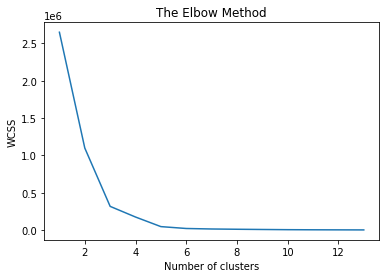

In [ ]:
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()